# Análisis y Forecasting Registros de la Propiedad del Automotor

En la página del IPECD, se encuentra este Dataset, que contiene el número de registros de autos y motos de Argentina, por provincia, desde el 2014 hasta el 2024. La idea es realizar un breve análisis estadístico y entrenar un modelo simple para predecir la cantidad de registros a futuro.

https://estadistica.corrientes.gob.ar/datosabiertos/files?dataset=5

## Preliminares

Comenzamos importando librerias necesarias, y definiendo funciones auxiliares.

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import datetime as dt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import numpy as np
import optuna as op
from matplotlib.ticker import MaxNLocator
from scipy.signal import periodogram
from matplotlib.offsetbox import AnchoredText
from statsmodels.graphics.tsaplots import plot_pacf
import scipy.stats as stats


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
def province_trend_plotter(df):
    plt.figure(figsize=(18,22))
    df2= df.copy()
    for i, (comb, df2) in enumerate(df2.groupby(['nombre_provincia_indec'],observed=False)):
        ax = plt.subplot(8,3, i+1)        
        sales = df2.sort_values(by='fecha').groupby('fecha')['cantidad'].sum().reset_index()
        trend = (sales.fecha - sales.iloc[0].fecha) // dt.timedelta(days=1)
        trend = trend.values.reshape(-1,1)
        model = make_pipeline(PolynomialFeatures(degree=1),
                            LinearRegression())
        model.fit(trend,sales.cantidad)
        y_pred = pd.Series(model.predict(trend), index=sales.fecha)
        
        ax.plot(sales.fecha,sales.cantidad,label='cantidad', color='black',marker='o',ls='--',markersize=1)
        y_pred.plot(ax=ax,color='red',label='trend')
        ax.set_title(comb)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(),rotation=45)    
        ax.legend()
    plt.tight_layout()
    plt.suptitle('Cantidad over time by Provincia',fontsize=20,y=1.02)   
    return ax 

In [5]:
def province_smooth_trend_plotter(df):
    df2 = df.copy()
    u_provin = df2['nombre_provincia_indec'].unique()
    yearp = df2.groupby(['nombre_provincia_indec',df2.index.year],observed=True)['cantidad'].mean().reset_index()
    plt.figure(figsize=(8,26))
    for i,w in enumerate(u_provin):
        ax = plt.subplot(len(u_provin),1,i+1)
        ax.plot(yearp[yearp.nombre_provincia_indec==w]['fecha'],yearp[yearp.nombre_provincia_indec==w]['cantidad'])
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(w)
    plt.tight_layout()
    return ax

In [6]:
def plot_periodogram(serie,wh,ax=None):     
    fs = pd.Timedelta('365D') / pd.Timedelta('1D')
    freq, spec = periodogram(serie, fs=fs,detrend='linear',scaling='spectrum')
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))  
    ax.step(freq, spec, color="blue")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title(f"Periodogram {wh}")
    return ax

In [7]:
def trend_plotter(df, place):
    plt.figure(figsize=(20,10))
    f, ax = plt.subplots(figsize=(20, 10))
    sns.lineplot(data=df, x="fecha", y="cantidad", linewidth=0.6, color='blue', ax=ax)
    ax.set_title(f'Trend {place}')
    return ax


In [8]:
def transform(X): #some feature engineering
    df = X.copy()

    # Create lag features
    df['lag_1'] = df['cantidad'].shift(1)
    df['lag_2'] = df['cantidad'].shift(2)
    df['lag_3'] = df['cantidad'].shift(3)
    df['lag_6'] = df['cantidad'].shift(6)
    df['lag_9'] = df['cantidad'].shift(9)
    df['lag_12'] = df['cantidad'].shift(12)

    # Create rolling mean features
    df['rolling_mean_3'] = df['cantidad'].rolling(window=3).mean()
    df['rolling_mean_6'] = df['cantidad'].rolling(window=6).mean()
    df['rolling_mean_12'] = df['cantidad'].rolling(window=12).mean()

    # Date-based features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday
    df['week'] = df.index.isocalendar().week
    df['weekend'] = df.index.weekday // 5
    df['semiweekly'] = np.where(df.index.weekday < 3, 0, 1)
    df['year_sin'] = np.sin(df['year'] / 1 * 2 * np.pi)#fourier features for yearly seasonality (every january)
    df['year_cos'] = np.cos(df['year'] / 1 * 2 * np.pi)
    df['month_sin'] = np.sin(df['month'] / 4 * 2 * np.pi)# for quarter seasonality
    df['month_cos'] = np.cos(df['month'] / 4 * 2 * np.pi)

    # Add indicator columns
    df['better_numbers'] = ((df.index >= '2017-06-01') & (df.index <= '2018-06-30')).astype(int)
    df['quarantine'] = (df.index.year == 2020).astype(int)
    df['change_milei'] = (df.index.year >= 2024).astype(int)

    # Exclude the target column ('cantidad') for KNN imputation
    feature_columns = [col for col in df.columns if col != 'cantidad']

    # Perform KNN imputation
    knn_imputer = KNNImputer(n_neighbors=5)
    df_imputed = knn_imputer.fit_transform(df[feature_columns])  # Only impute feature columns

    # Convert back to DataFrame with original columns and index
    df[feature_columns] = pd.DataFrame(df_imputed, columns=feature_columns, index=df.index)

    return df

In [33]:


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


## Lectura y Análisis de Datos

Comenzamos importando y dando un primer vistazo a nuestro dataset.

In [9]:
df = pd.read_csv('DNRPA.csv', parse_dates=['fecha'])

In [10]:
df

,fecha,nombre_provincia_indec,tipo_vehiculo,cantidad
0,2014-01-01,CABA,auto,15737
1,2014-02-01,CABA,auto,9521
2,2014-03-01,CABA,auto,8638
3,2014-04-01,CABA,auto,8369
4,2014-05-01,CABA,auto,9189
...,...,...,...,...
6187,2024-07-01,Tierra Del Fuego,moto,38
6188,2024-08-01,Tierra Del Fuego,moto,89
6189,2024-08-01,Tierra Del Fuego,auto,403
6190,2024-09-01,Tierra Del Fuego,auto,451


Dado que en este análisis no nos centraremos en el tipo de vehículo, descartamos dicha columna.

In [11]:
df = df.drop(columns='tipo_vehiculo')

In [12]:
df.head()

,fecha,nombre_provincia_indec,cantidad
0,2014-01-01,CABA,15737
1,2014-02-01,CABA,9521
2,2014-03-01,CABA,8638
3,2014-04-01,CABA,8369
4,2014-05-01,CABA,9189


Comencemos viendo la cantidad de vehículos por provincia, y veamos si podemos establecer alguna tendencia.

In [13]:
df.set_index('fecha', inplace=True)

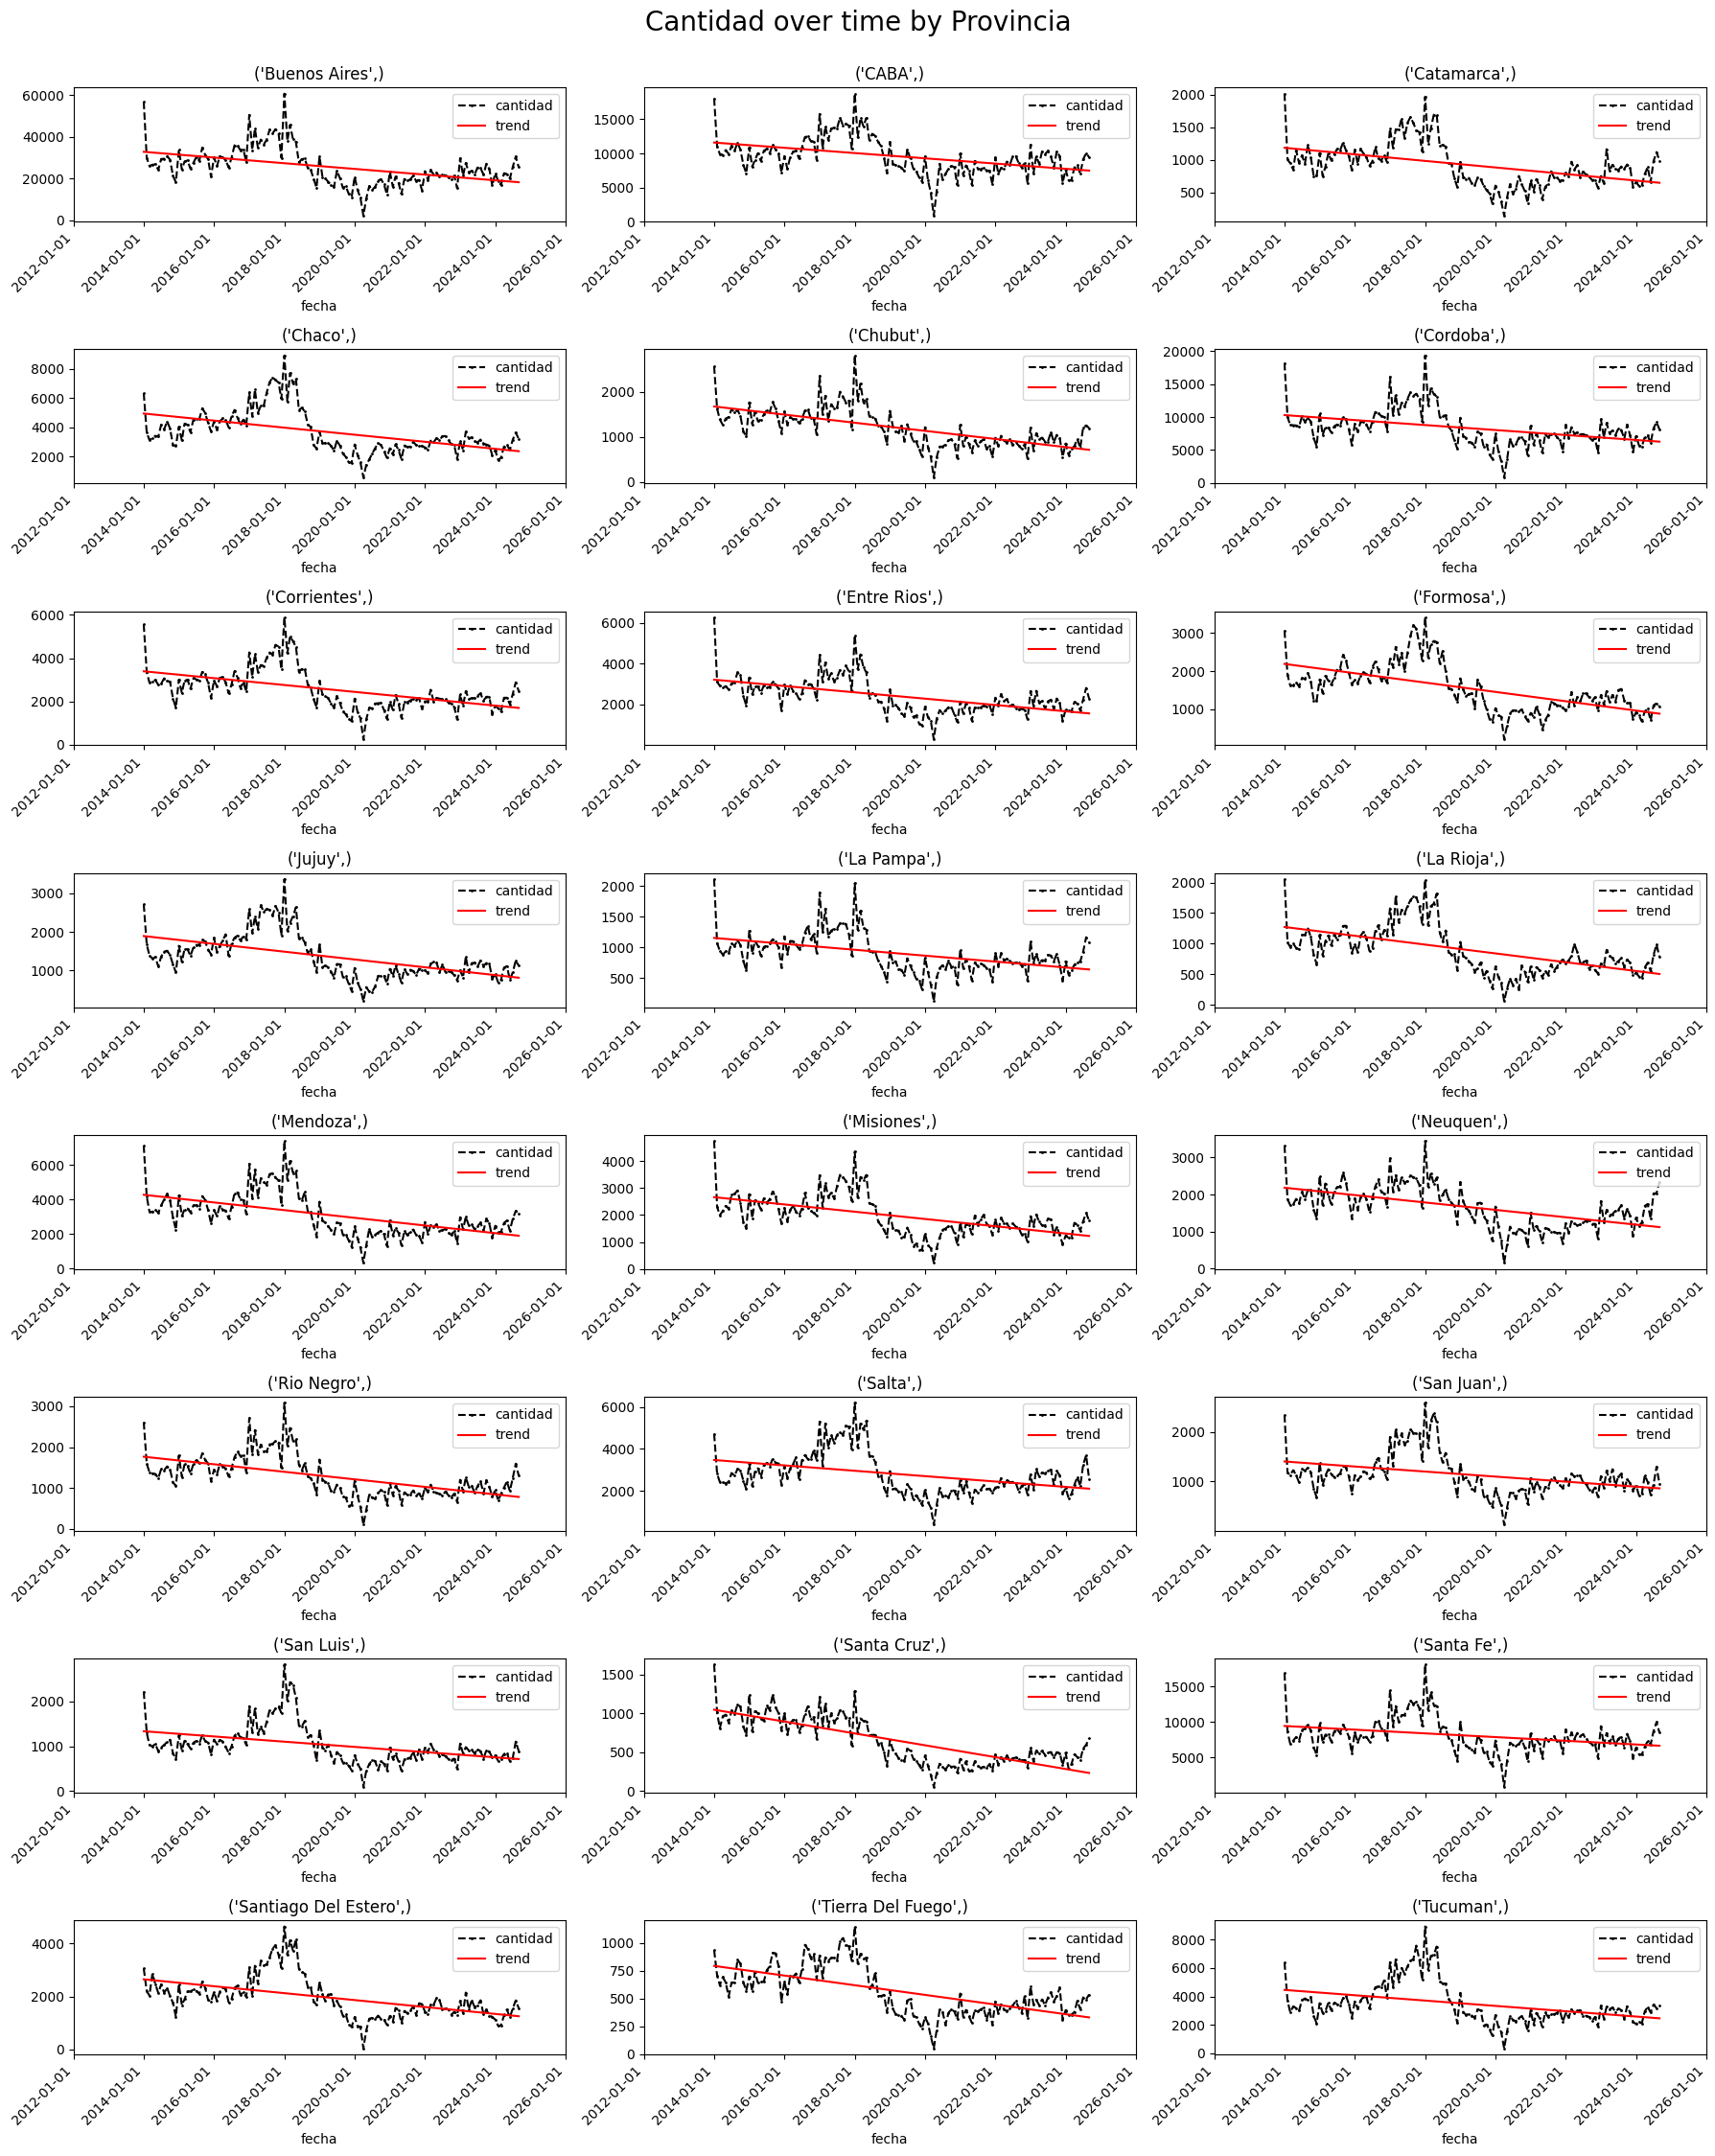

In [14]:
province_trend_plotter(df)
plt.show()


Claramente vemos una tendencia similar en cada provincia, con picos entre 2017-2018 y 2020-2021. Además, quitando estos picos, vemos una tendencia decreciente durante el periodo estudiado. Quizás se podría afirmar que la tendencia es mas bien cúbica, sin embargo, los números al inicio del período cuestionan esta afirmación.

La similitud entre la tendencia entre las provincias se puede apreciar mejor en el siguiente gráfico.

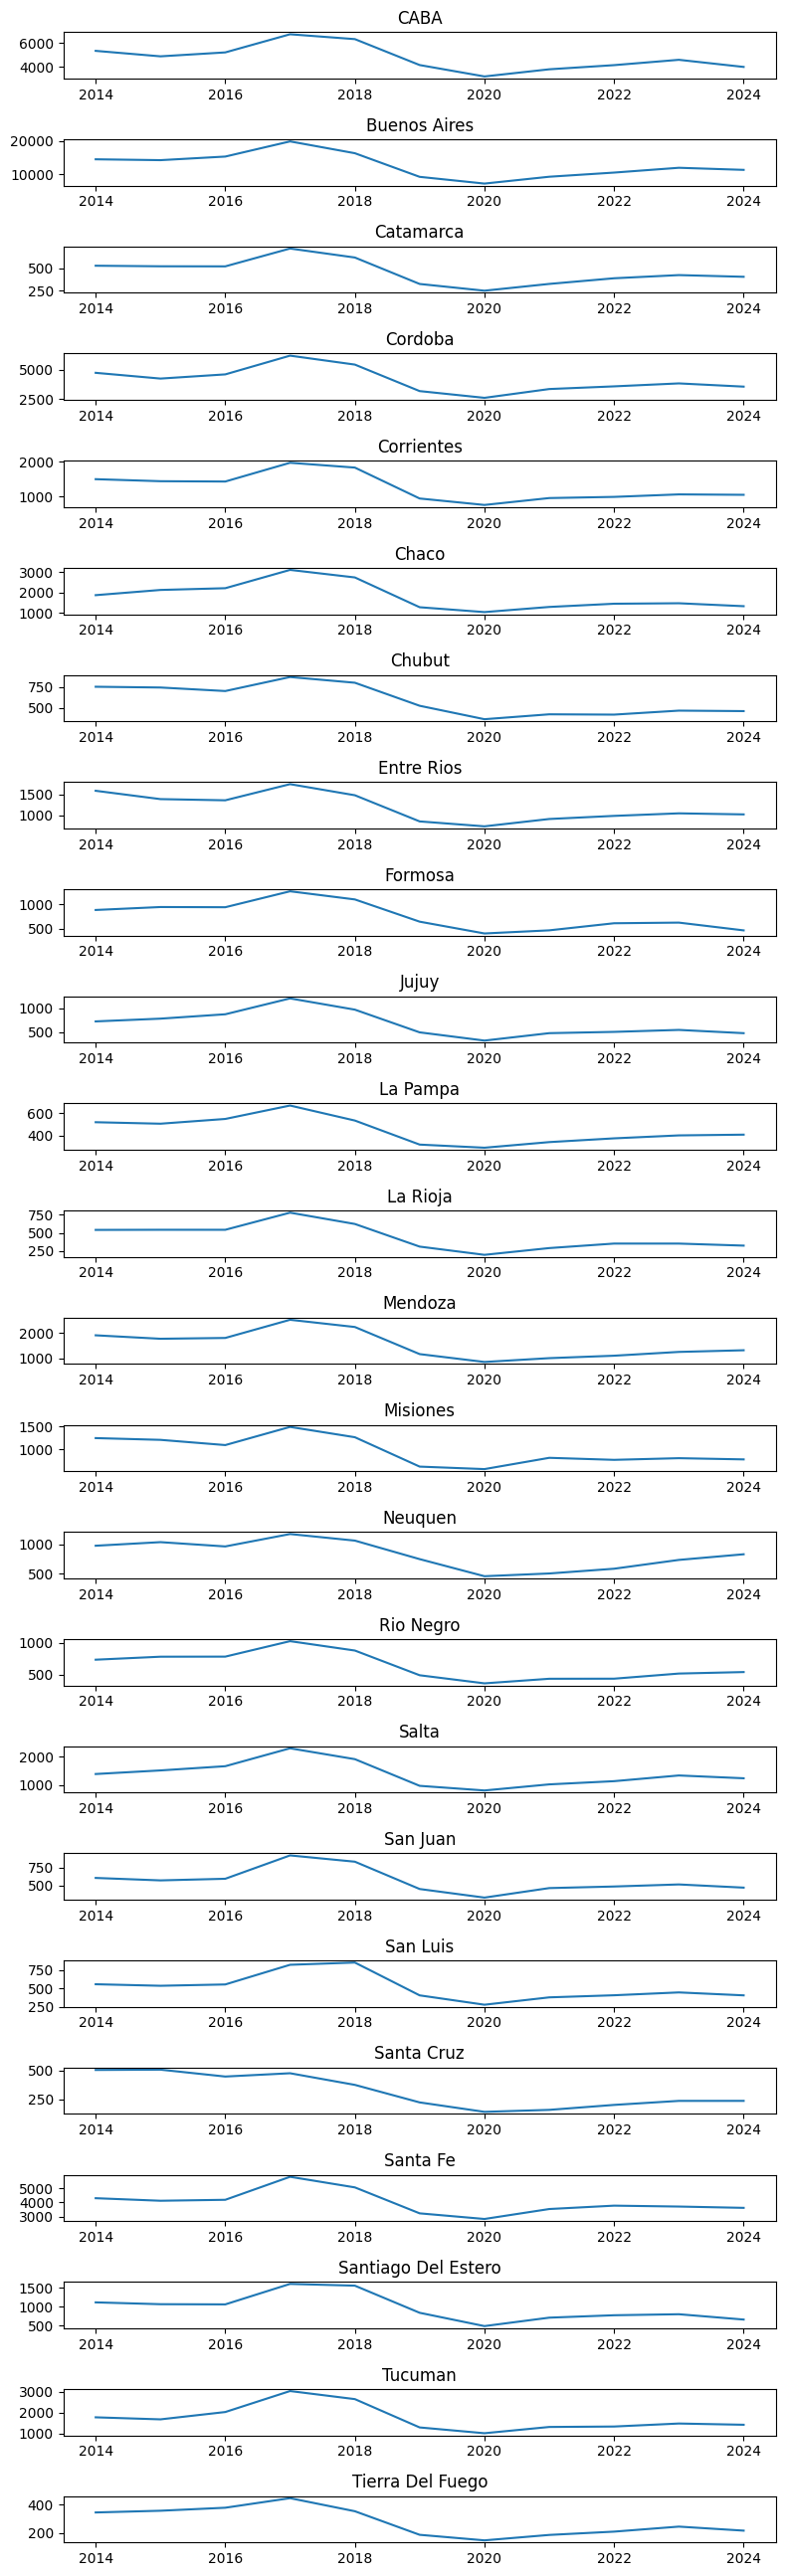

In [15]:
province_smooth_trend_plotter(df)
plt.show()

Ahora bien, como se puede ver en los gráficos previos, si bien la tendencia es similar, los números de cada provincia con respecto a otra varían considerablemente. Veamos el siguiente boxplot.

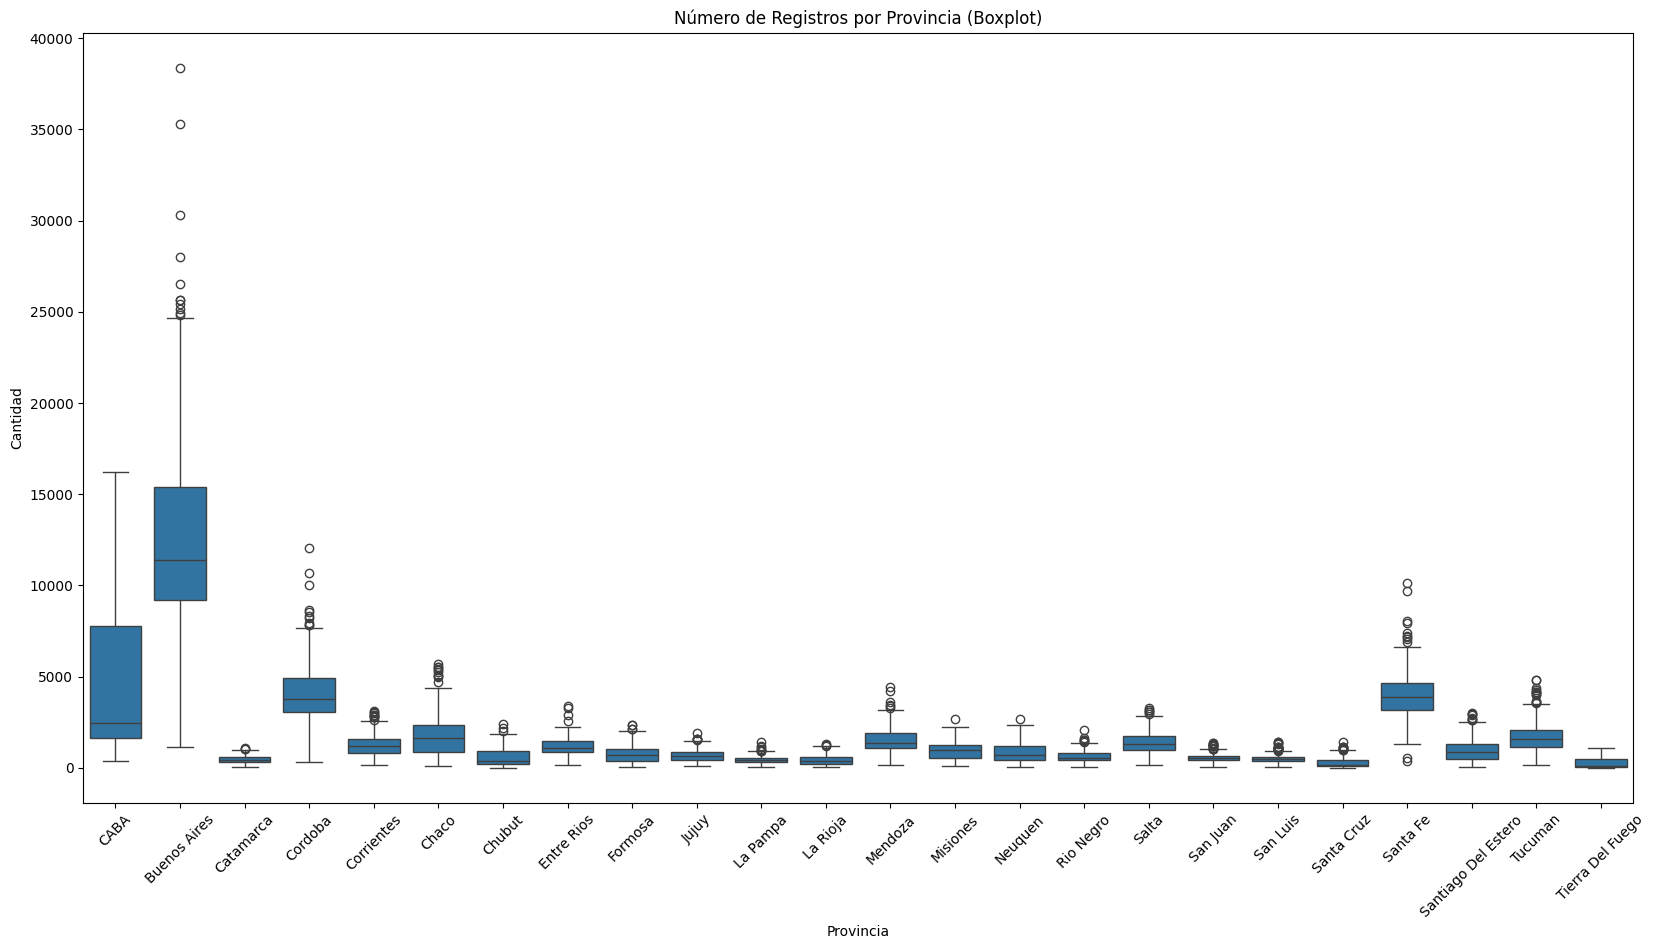

In [16]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='nombre_provincia_indec', y='cantidad', data=df)
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.title("Número de Registros por Provincia (Boxplot)")
plt.xlabel('Provincia')
plt.ylabel('Cantidad')
plt.show()

Claramente la media de registros en distritos como Buenos Aires, CABA y Córdoba es superior al resto. Además, la mayoría de las provincias presenta outliers de una mayor cantidad de registro. Esto coincide con lo sugerido por el gráfico de las tendencias, pues si quitamos los números del 2014 y 2017-2018, vemos que incluso contando el declive en 2020-2021, la tendencia es lineal decreciente.

Este mayor número de registros en ciertas provincias, podemos verlo claramente si graficamos boxplots correspondientes a Argentina en general.

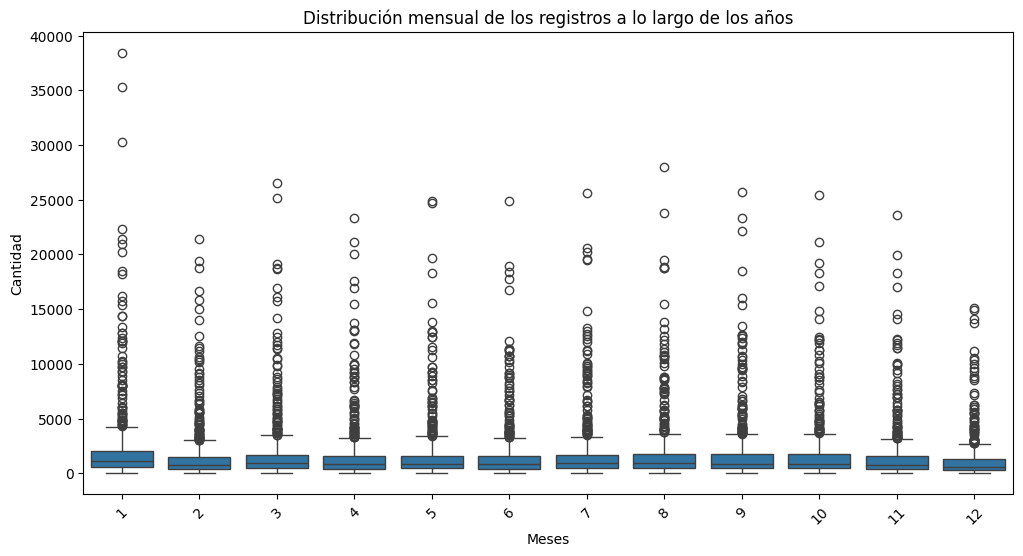

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df.index.month, y=df['cantidad'])
plt.xticks(rotation=45)
plt.title("Distribución mensual de los registros a lo largo de los años")
plt.xlabel("Meses")
plt.ylabel("Cantidad")
plt.show()


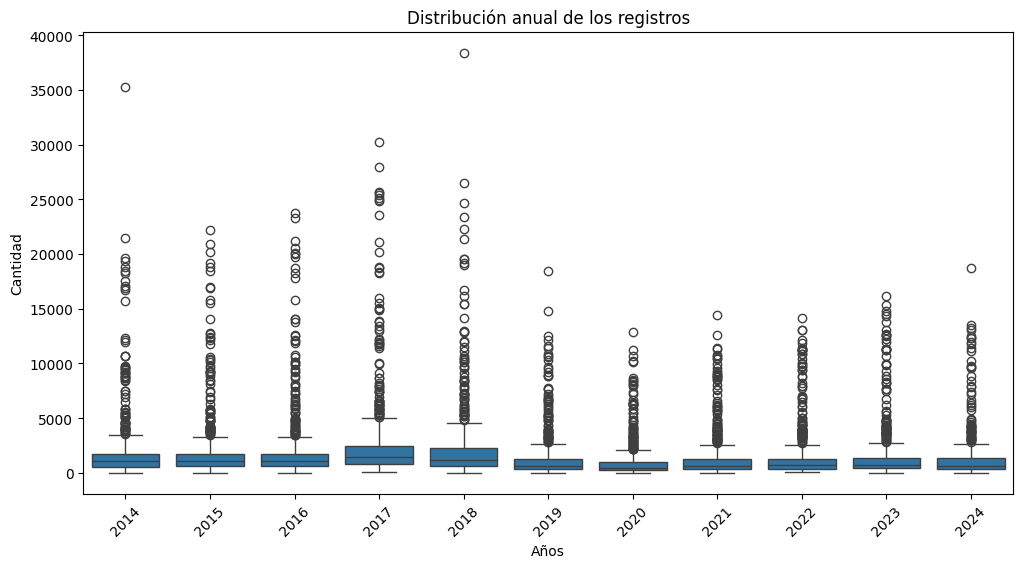

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df.index.year, y=df['cantidad'], showfliers=True)  # Show outliers
plt.xticks(rotation=45)
plt.title("Distribución anual de los registros")
plt.xlabel("Años")
plt.ylabel("Cantidad")
plt.show()


Dado que la mayoría de las provincias tienen números de registros similares, la presencia de outliers en valores altos es generada por distritos como CABA, Buenos Aires, Córdoba y Santa Fé.

En efecto, si agrupamos los valores y consideramos los registros mensuales en toda argentina, el gráfico de cajas tiene otro aspecto.

In [21]:
df_grouped = df.copy()
df_grouped = df_grouped.groupby(['fecha'])['cantidad'].sum().reset_index()
df_grouped.set_index('fecha', inplace=True)

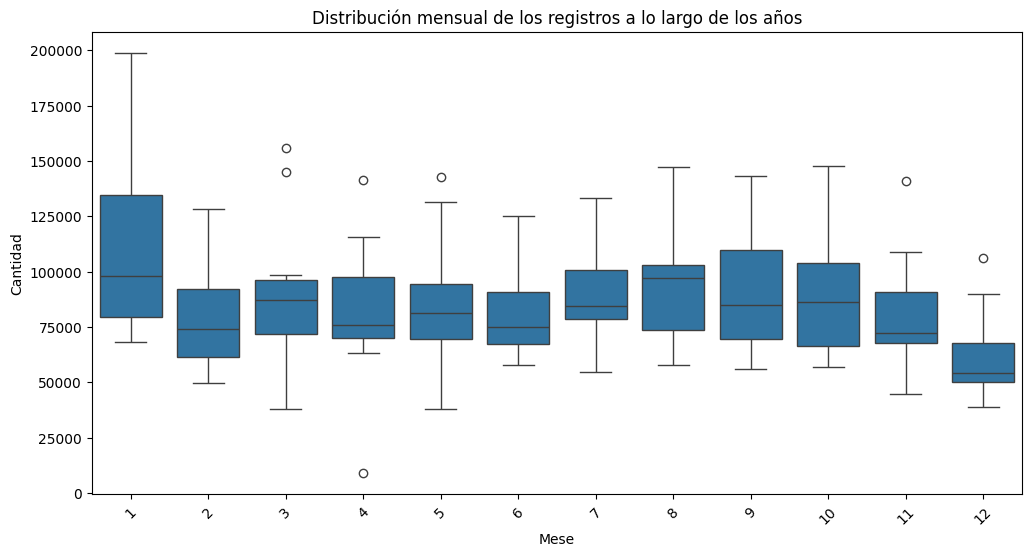

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_grouped.index.month, y=df_grouped['cantidad'])
plt.xticks(rotation=45)
plt.title("Distribución mensual de los registros a lo largo de los años")
plt.xlabel("Meses")
plt.ylabel("Cantidad")
plt.show()

Claramente en enero se producen el mayor número de registro, así como en diciembre el menor. Esto coincide con el hecho de que, al cambiar el año, el valor del modelo cambia, pues si bien hay un mes de diferencia, el modelo es del año siguiente.

Ahora, centrémonos en análisis los registros mensuales en toda Argentina. Comencemos graficando los registros, como hicimos para cada provincia.

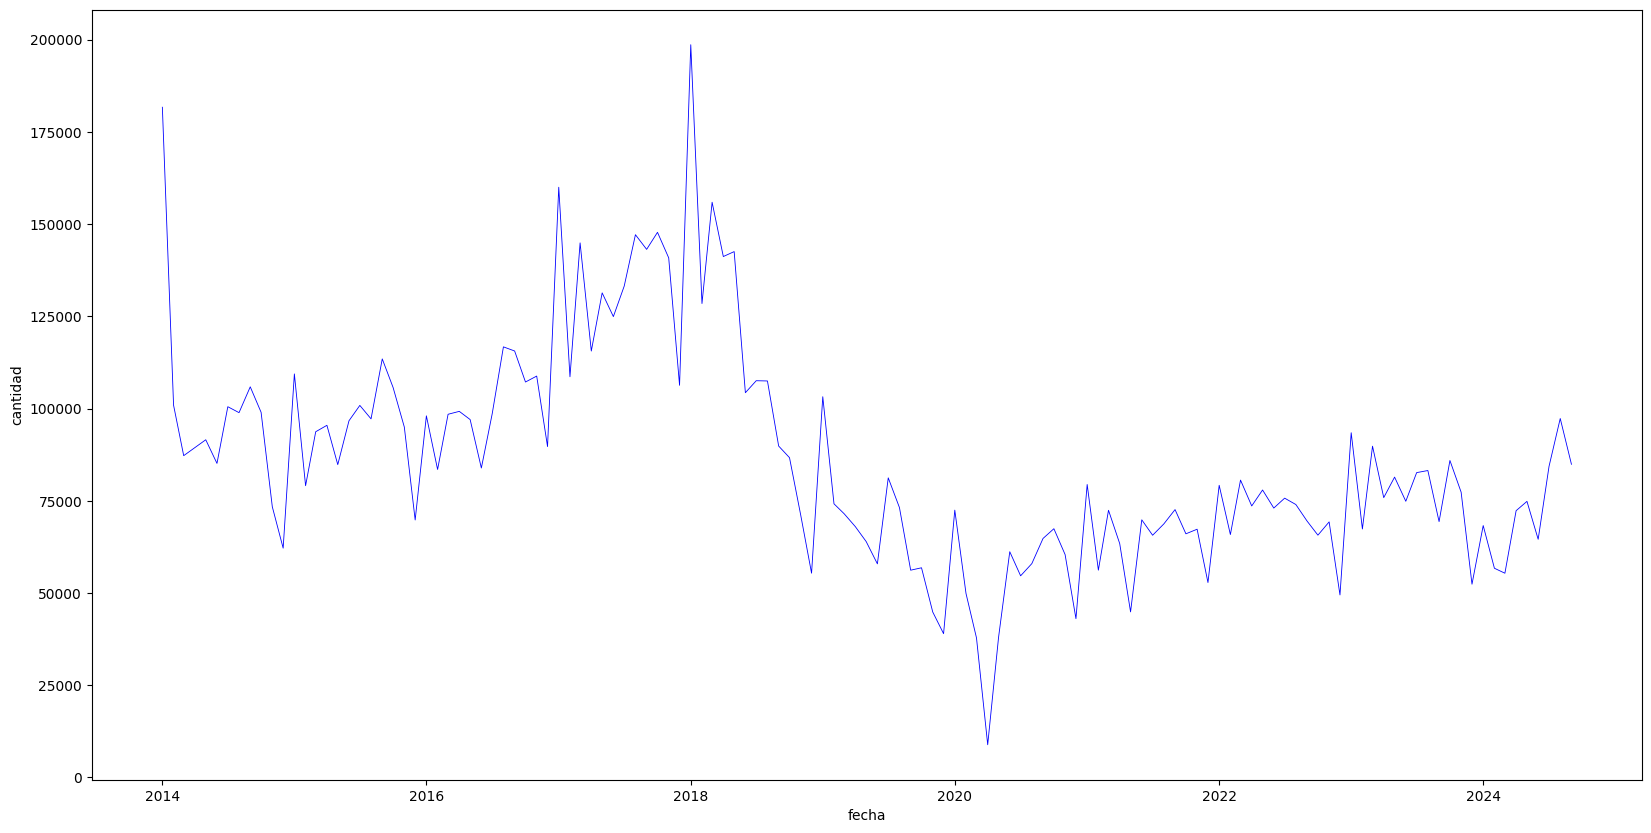

In [24]:
f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=df_grouped, x="fecha", y="cantidad", linewidth=0.6, color='blue', ax=ax)
plt.show()

Claramente la tendencia es similar a la vista en las provincias. También podemos añadir moving averages de 3, 6 y 12 meses para distinguir mejor la tendencia.

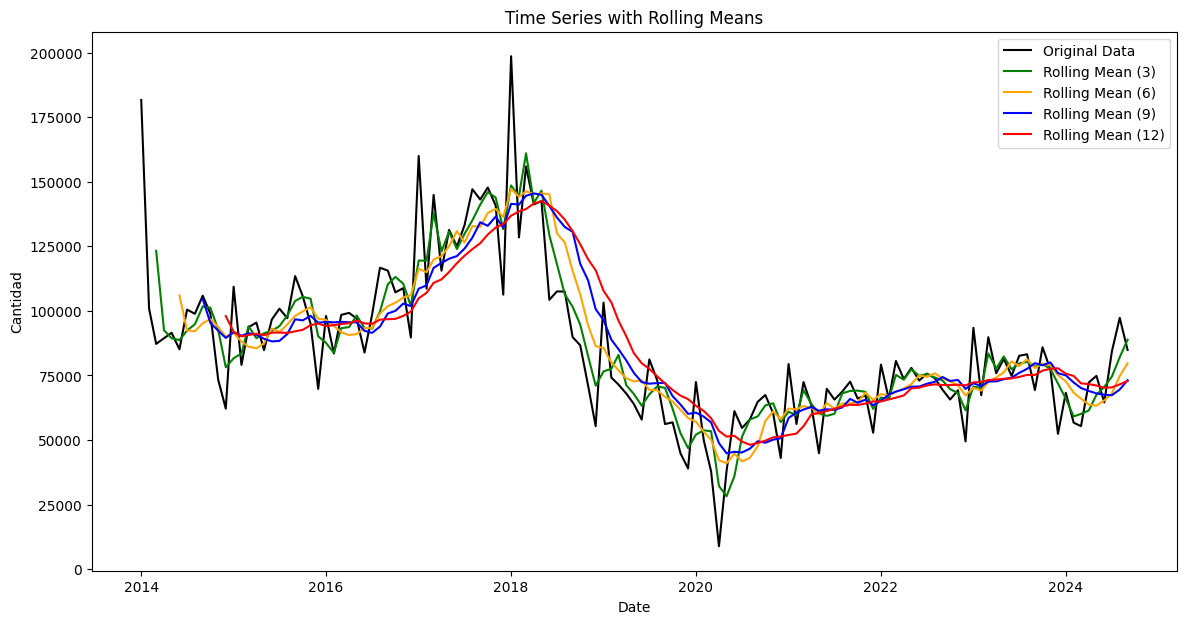

In [28]:
plt.figure(figsize=(14, 7))

# Original time series (for context)
sns.lineplot(data=df_grouped, x=df_grouped.index, y='cantidad', label='Original Data', color='black')

# Rolling mean (3, 6, 12 months)
sns.lineplot(data=df_grouped, x=df_grouped.index, y=df_grouped['cantidad'].rolling(window=3).mean(), label='Rolling Mean (3)', color='green')
sns.lineplot(data=df_grouped, x=df_grouped.index, y=df_grouped['cantidad'].rolling(window=6).mean(), label='Rolling Mean (6)', color='orange')
sns.lineplot(data=df_grouped, x=df_grouped.index, y=df_grouped['cantidad'].rolling(window=9).mean(), label='Rolling Mean (9)', color='blue')
sns.lineplot(data=df_grouped, x=df_grouped.index, y=df_grouped['cantidad'].rolling(window=12).mean(), label='Rolling Mean (12)', color='red')


plt.title('Time Series with Rolling Means')
plt.xlabel('Date')
plt.ylabel('Cantidad')
plt.legend()
plt.show()

Las medias que mejor se adaptan a la gráfica son las de 3 y 12 meses, lo que nos sugiere que podría haber seasonality trimestral y anual. La anual, justamente, coincide con el incremento de registros en enero de cada año, como se explicó mas arriba. Para confirmar la trimestral, grafiquemos el periodograma. 

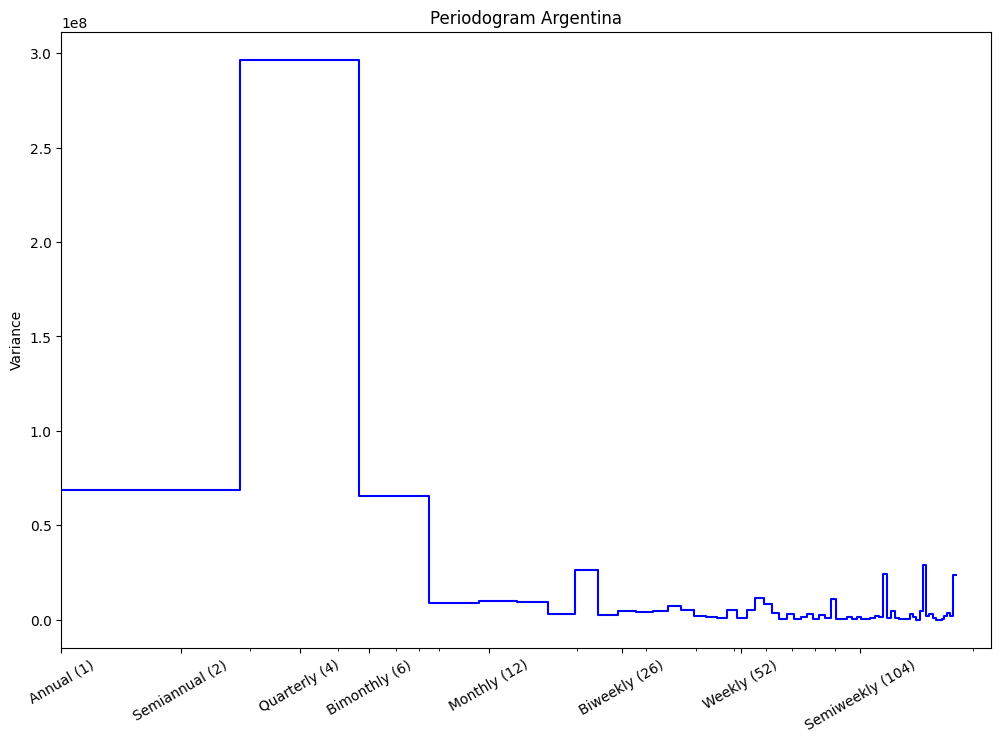

In [31]:
plot_periodogram(df_grouped.groupby('fecha').cantidad.mean(),'Argentina')
plt.show()

A partir del periodograma, podemos ver como la seasonality más importante es trimestral. En menor medida, podemos detectar cierta bimensualidad y mensualidad.

Dirigiéndonos de a poco a entrenar el modelo para predecir, los gráficos anteriores nos sugieren añadir lags a nuestro conjunto de datos. Veamos si alguno de ellos presenta cierta correlación.

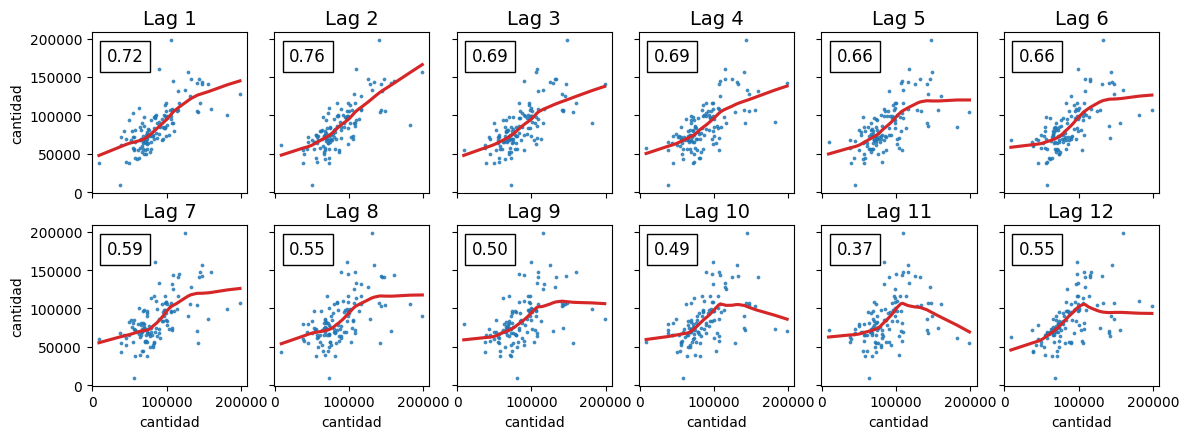

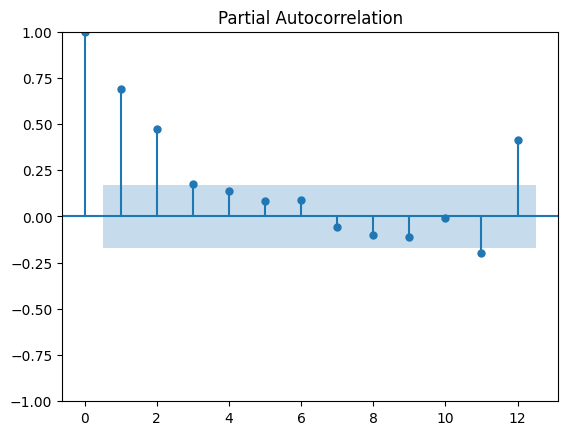

In [35]:
_ = plot_lags(df_grouped.cantidad, lags=12, nrows=2)
_ = plot_pacf(df_grouped.cantidad, lags=12)

A partir de estos gráficos, más el análisis realizado antes, consideramos oportuno añadir lags 1 y 2, dada la alta autocorrelación y la aparente bimensualidad y mensualidad. Además, los lags 3, 6, 9 y 12 serían oportunos dada la trimestralidad y anualidad.

## Preprocesamiento y Feature Engineering

En la función transform, se puede observar el feature engineering realizado. Aquí simplemente lo aplicaremos. 

In [36]:
df_transformed = transform(df_grouped)

In [38]:
df_transformed

,cantidad,lag_1,lag_2,lag_3,lag_6,lag_9,lag_12,rolling_mean_3,rolling_mean_6,rolling_mean_12,...,week,weekend,semiweekly,year_sin,year_cos,month_sin,month_cos,better_numbers,quarantine,change_milei
fecha,,,,,,,,,,,,,,,,,,,,,
2014-01-01,181687,96368.4,88960.0,107444.8,111032.6,105607.8,140577.0,101997.400000,106716.633333,107623.283333,...,1.0,0.0,0.0,-1.132776e-12,1.0,1.000000e+00,6.123234e-17,0.0,0.0,0.0
2014-02-01,100906,181687.0,120161.6,144067.4,137579.0,111975.6,106418.4,138171.066667,135295.000000,129112.733333,...,5.0,1.0,1.0,-1.132776e-12,1.0,1.224647e-16,-1.000000e+00,0.0,0.0,0.0
2014-03-01,87226,100906.0,181687.0,118718.0,139878.0,117778.2,126713.6,123273.000000,133705.066667,128179.416667,...,9.0,1.0,1.0,-1.132776e-12,1.0,-1.000000e+00,-1.836970e-16,0.0,0.0,0.0
2014-04-01,89431,87226.0,100906.0,181687.0,124133.0,119304.8,105118.4,92521.000000,121132.866667,119961.633333,...,14.0,0.0,0.0,-1.132776e-12,1.0,-2.449294e-16,1.000000e+00,0.0,0.0,0.0
2014-05-01,91535,89431.0,87226.0,100906.0,103561.4,107976.6,104554.4,89397.333333,92707.766667,98676.600000,...,18.0,0.0,1.0,-1.132776e-12,1.0,1.000000e+00,3.061617e-16,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,74835,72305.0,55356.0,56705.0,77318.0,83195.0,81412.0,67498.666667,63310.833333,71094.416667,...,18.0,0.0,0.0,1.585375e-14,1.0,1.000000e+00,3.061617e-16,0.0,0.0,1.0
2024-06-01,64551,74835.0,72305.0,55356.0,52383.0,69341.0,74864.0,70563.666667,65338.833333,70235.000000,...,22.0,1.0,1.0,1.585375e-14,1.0,3.673940e-16,-1.000000e+00,0.0,0.0,1.0
2024-07-01,84314,64551.0,74835.0,72305.0,68281.0,85921.0,82629.0,74566.666667,68011.000000,70375.416667,...,27.0,0.0,0.0,1.585375e-14,1.0,-1.000000e+00,-4.286264e-16,0.0,0.0,1.0


Dado que emplearemos un modelo híbrido, es decir, primero utilizaremos un modelo linear, para intentar capturar la tendencia, y luego pasaremos el residuo a un modelo basado en árboles de decisión, necesitamos escalar los datos, pues, como podemos ver, las magnitudes entre las columnas difieren considerablemente.

In [39]:
X= df_transformed.copy()
y = X.pop('cantidad')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Initialize the scaler

scaler1 = RobustScaler()
scaler2 = RobustScaler()
# Scale the target (y)
y_train_s = scaler1.fit_transform(y_train.values.reshape(-1,1))
y_test_s = scaler1.transform(y_test.values.reshape(-1,1))

# Scale the features (X)
X_train_s = scaler2.fit_transform(X_train)
X_test_s =scaler2.transform(X_test)

y_train_s = pd.Series(y_train_s.flatten(), index=y_train.index)  
y_test_s = pd.Series(y_test_s.flatten(), index=y_test.index)

X_train_s = pd.DataFrame(X_train_s, columns=X_train.columns, index=X_train.index) 
X_test_s = pd.DataFrame(X_test_s, columns=X_test.columns, index=X_test.index)

## Entrenamiento del Modelo y Pruebas

Pasamos ahora a entrenar el modelo, utilizando Optuna como optimizador, y KFold para intentar evitar que nuestro modelo haga overfitting sobre el conjunto de entrenamiento, lo cual es probable pues nuestro dataset es pequeño.

In [40]:
def objective(trial):
    # Set the parameters for LightGBM
    param = {
        "objective": "regression",
        "metric": "l2",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
        "verbose": -1,
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    mse_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train_s.iloc[train_idx], X_train_s.iloc[val_idx]
        y_tr, y_val = y_train_s.iloc[train_idx], y_train_s.iloc[val_idx]

        # Train a Linear Regression model
        lin_reg = Ridge()
        lin_reg.fit(X_tr, y_tr)
        
        # Predict with Linear Regression and compute residuals
        y_tr_pred = lin_reg.predict(X_tr)
        y_val_pred = lin_reg.predict(X_val)
        
        residuals_tr = y_tr - y_tr_pred
        residuals_val = y_val - y_val_pred

        # Train LightGBM on the residuals
        train_data = lgb.Dataset(X_tr, label=residuals_tr)
        val_data = lgb.Dataset(X_val, label=residuals_val, reference=train_data)

        model = lgb.train(param, train_data, valid_sets=[val_data])

        # Predict residuals using LightGBM
        residuals_pred = model.predict(X_val)

        # Final prediction: linear model prediction + residual prediction
        y_final_pred = y_val_pred + residuals_pred

          # Ensure that both y_val and y_final_pred are 1D arrays (flatten if necessary)
        #y_val = y_val.values.flatten() if isinstance(y_val, pd.Series) else y_val
        #y_final_pred = y_final_pred.flatten()

        #print(y_val)
        #print(y_final_pred)
        # Calculate MSE for the current fold
        mse = np.sqrt(mean_squared_error(y_val, y_final_pred))
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Run Optuna
op.logging.set_verbosity(op.logging.INFO)
study = op.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Get best hyperparameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

[I 2025-02-15 14:46:32,987] A new study created in memory with name: no-name-f7894965-4955-4ecd-b956-becae6c2ad13
[I 2025-02-15 14:46:33,210] Trial 0 finished with value: 0.2751999726918584 and parameters: {'learning_rate': 0.037204039666783685, 'num_leaves': 97, 'max_depth': 4, 'min_data_in_leaf': 22, 'lambda_l1': 0.00043550825203102515, 'lambda_l2': 0.00013853310107521727, 'feature_fraction': 0.6267970851911469}. Best is trial 0 with value: 0.2751999726918584.
[I 2025-02-15 14:46:33,398] Trial 1 finished with value: 0.2771304022774015 and parameters: {'learning_rate': 0.10253611984872045, 'num_leaves': 39, 'max_depth': 3, 'min_data_in_leaf': 32, 'lambda_l1': 0.0001415035939116346, 'lambda_l2': 0.0005103456341716546, 'feature_fraction': 0.9246339014182262}. Best is trial 0 with value: 0.2751999726918584.
[I 2025-02-15 14:46:33,554] Trial 2 finished with value: 0.28435883024233316 and parameters: {'learning_rate': 0.04036741789782754, 'num_leaves': 45, 'max_depth': 5, 'min_data_in_leaf

Best parameters: {'learning_rate': 0.08595894054353947, 'num_leaves': 89, 'max_depth': 6, 'min_data_in_leaf': 27, 'lambda_l1': 3.4977024007252377e-07, 'lambda_l2': 1.343864740050602e-06, 'feature_fraction': 0.8127395231629295}


Guardamos los parámetros óptimos para el modelo en un diccionario, para no tener que entrenarlo de nuevo.

In [ ]:
best_param = {
        "objective": "regression",
        "metric": "l2",
        "boosting_type": "gbdt",
        "learning_rate": 0.08595894054353947,
        'num_leaves': 89,
        'max_depth': 6,
        'min_data_in_leaf': 27,
        'lambda_l1': 3.4977024007252377e-07,
        'lambda_l2': 1.343864740050602e-06,
        'feature_fraction': 0.8127395231629295,
            }

{'learning_rate': 0.08595894054353947,
 'num_leaves': 89,
 'max_depth': 6,
 'min_data_in_leaf': 27,
 'lambda_l1': 3.4977024007252377e-07,
 'lambda_l2': 1.343864740050602e-06,
 'feature_fraction': 0.8127395231629295}

Ahora, entrenamos el modelo final y calculamos el error cuadrático medio.

In [42]:
# Train the final Linear Regression model
lin_reg_final = LinearRegression()
lin_reg_final.fit(X_train_s, y_train_s)

# Predict y_train using Linear Regression
y_train_pred = lin_reg_final.predict(X_train_s)

# Compute residuals
residuals_train = y_train_s - y_train_pred

# Train the final LightGBM model on residuals
train_data = lgb.Dataset(X_train_s, label=residuals_train)
lgb_final = lgb.train(best_params, train_data)

# Predict on test data
y_test_pred_lr = lin_reg_final.predict(X_test_s)  # Linear model prediction
y_test_pred_residuals = lgb_final.predict(X_test_s)  # Residual prediction

# Final predictions = Linear model prediction + Residual correction
y_test_final_pred = y_test_pred_lr + y_test_pred_residuals

mean_squared_error(y_test_s, y_test_final_pred)

0.006225395930137712

Si bien el error en el conjunto de pruebas es pequeño, siempre es bueno comparar cómo se ajusta nuestras predicciones con los datos originales.

In [43]:

df_og_pred = df_grouped.copy()
X= scaler2.transform(X)
X = pd.DataFrame(X, columns=df_transformed.drop(columns=['cantidad']).columns, index=df_transformed.index) 
y1 = lin_reg_final.predict(X)
y2 = lgb_final.predict(X)
y_X = y1+y2
df_og_pred['cantidad'] = scaler1.inverse_transform(y_X.reshape(-1,1))

In [48]:
cantidad = df_grouped.sort_values(by='fecha').groupby('fecha')['cantidad'].sum().reset_index()
trend = (cantidad.fecha - cantidad.iloc[0].fecha) // dt.timedelta(days=1)
trend = trend.values.reshape(-1,1)
model = make_pipeline(PolynomialFeatures(degree=1),
                          LinearRegression())
model.fit(trend,cantidad.cantidad)
y_pred_l = pd.Series(model.predict(trend), index=cantidad.fecha)


In [54]:
X_test_for_plotting = X_test_s.copy()
X_test_for_plotting['cantidad'] = scaler1.inverse_transform(y_test_final_pred.reshape(-1,1))

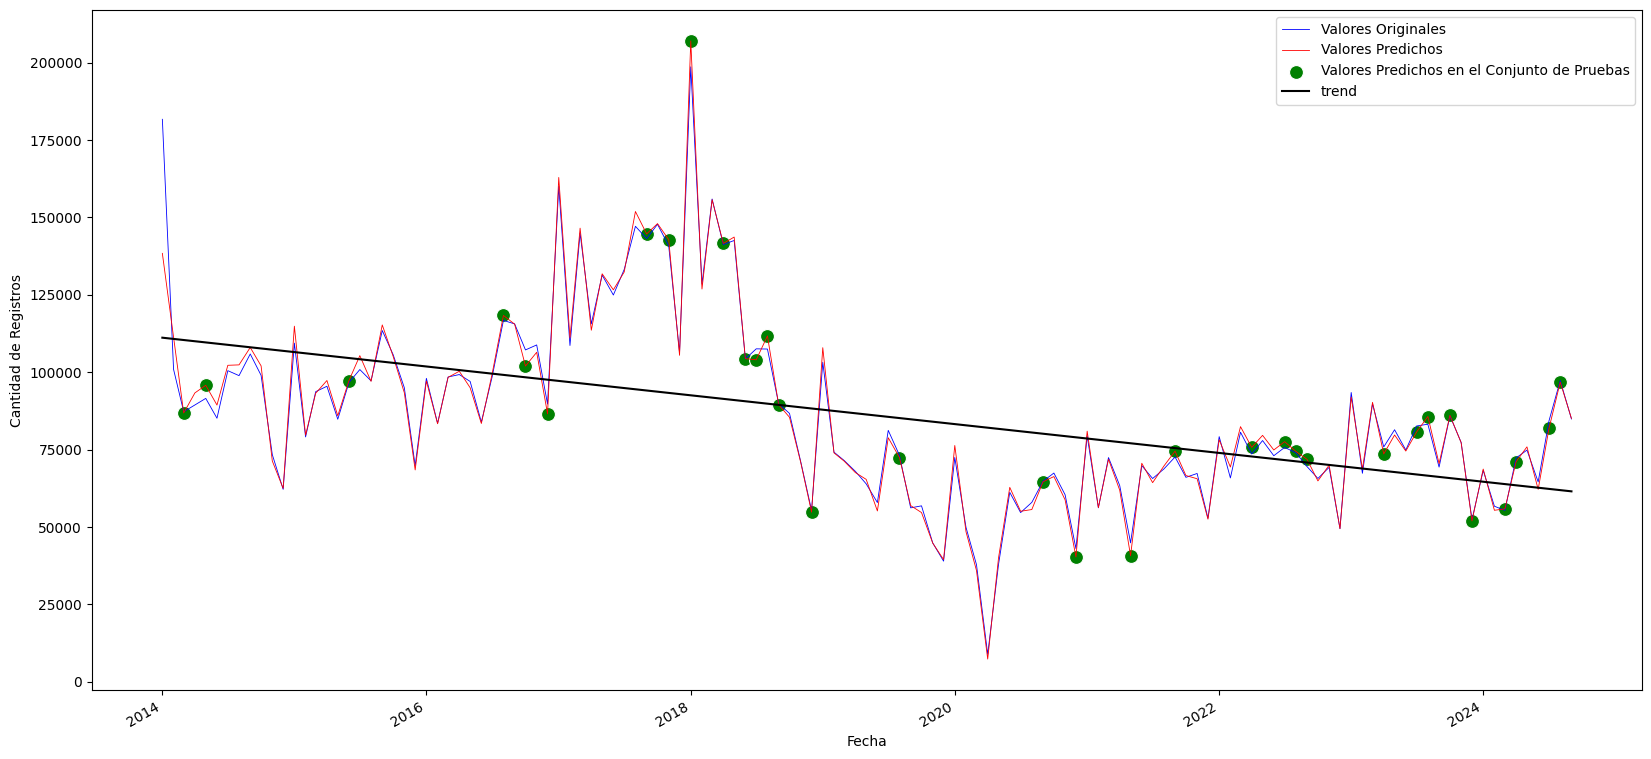

In [58]:
# Create the plot
f, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=df_grouped, x="fecha", y="cantidad", linewidth=0.6, color='blue', ax=ax, label="Valores Originales")


sns.lineplot(data=df_og_pred, x='fecha', y="cantidad", linewidth=0.6, color='red', ax=ax, label="Valores Predichos")

sns.scatterplot(data=X_test_for_plotting, x="fecha", y="cantidad", color='green', ax=ax, label="Valores Predichos en el Conjunto de Pruebas", s=100)

y_pred_l.plot(ax=ax,color='black',label='trend')

ax.legend()
ax.set_xlabel('Fecha')
ax.set_ylabel('Cantidad de Registros')

plt.show()

Más allá de que los puntos predichos son muy próximos a los valores, y el modelo parece detectar de manera convincente los diferentes períodos, la línea roja nos podría hacer pensar en overfitting. Para ello podemos realizar tests a los residuos para evaluar el rendimiento del modelo.

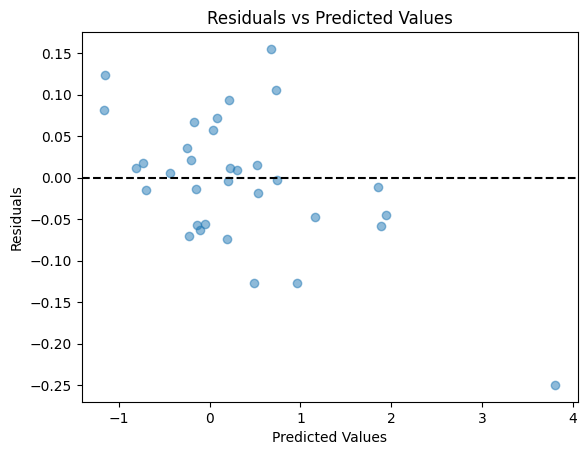

In [59]:
residuals = y_test_s - y_test_final_pred

plt.scatter(y_test_final_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()


Claramente los residuos no siguen un patrón, lo que es un buen indicio.

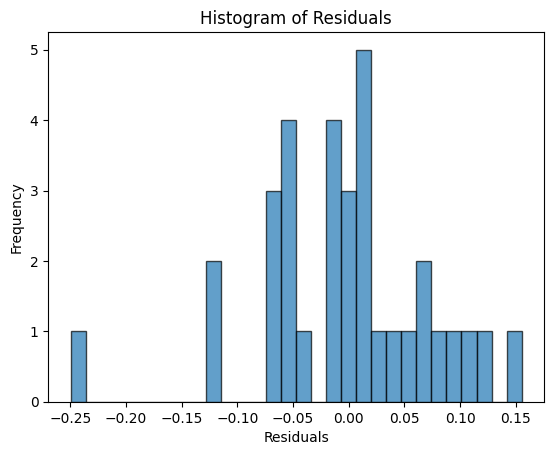

In [60]:
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

El histograma demuestra cierta normalidad, lo cual es un buen indicio.

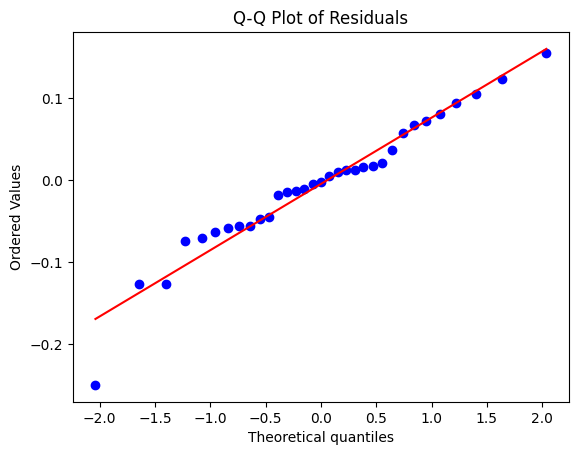

In [62]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

Los residuos tienen una tendencia lineal, lo cual es bueno.

Podemos ver en casi todos los gráficos la presencia de un gran outlier, tratemos de identificarlo

In [ ]:
residuals < -0.20


fecha
2024-03-01    False
2022-09-01    False
2018-08-01    False
2018-09-01    False
2016-10-01    False
2023-12-01    False
2024-04-01    False
2016-12-01    False
2016-08-01    False
2018-04-01    False
2023-08-01    False
2022-08-01    False
2014-05-01    False
2019-08-01    False
2022-07-01    False
2018-01-01     True
2017-11-01    False
2018-12-01    False
2021-09-01    False
2024-08-01    False
2024-07-01    False
2014-03-01    False
2018-06-01    False
2023-10-01    False
2023-04-01    False
2023-07-01    False
2020-09-01    False
2017-09-01    False
2022-04-01    False
2018-07-01    False
2020-12-01    False
2015-06-01    False
2021-05-01    False
dtype: bool


Al parecer, todos los residuos son muy cercanos al cero excepto el predicho para enero de 2018, lo cual podemos ver en el gráfico de los valores predichos. En cierta manera, si bien el número de registros creció durante 2017 hacia 2018, y enero es el mes con mayor número de registros en promedio, dicho valor fue bastante alto.

Para el último test con los residuos, eliminemos el outlier, pues el test de Shapiro es sensible a ellos.

In [67]:
residuals = residuals[residuals > -0.20]

In [68]:
stat, p_value = stats.shapiro(residuals)
print(f"p-value: {p_value}")

p-value: 0.7606115579441382


Dado que el valor es cercano a 1, no se rechaza la hipótesis de que los residuos vienen de una distribución normal.

## Predicción a Futuro

Para terminar con este análisis, podríamos intentar predecir los registros a futuro. Para ello, necesitamos crear nuevas fechas, preprocesarlas y pasarlas por nuestro modelo.

In [69]:
# Create future dates starting from the first of each month (next 6 months)
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

future_df = pd.DataFrame(index=future_dates)

In [70]:
df_extended = pd.concat([df_grouped, future_df]) 

In [72]:
# Apply the same feature transformation (without imputation on future)
df_extended = transform(df_extended)

In [73]:
# Keep only future dates
future_features = df_extended.loc[future_dates]

In [74]:
future_features = future_features.drop(columns='cantidad')

In [75]:
future_features = pd.DataFrame(scaler2.transform(future_features), columns=future_features.columns, index=future_features.index)

In [76]:
future_pred_lin = lin_reg_final.predict(future_features)  # Linear model prediction

future_pred_lgb = lgb_final.predict(future_features)  # Residual prediction

# Final predictions = Linear model prediction + Residual correction
future_pred = future_pred_lin + future_pred_lgb

In [77]:
future_features['cantidad'] = scaler1.inverse_transform(future_pred.reshape(-1,1))

In [78]:
future_grouped = future_features[['cantidad']].copy()

In [79]:
future_grouped

,cantidad
2024-10-01,92503.290737
2024-11-01,68956.714295
2024-12-01,53769.849063
2025-01-01,74644.922827
2025-02-01,68008.273436
2025-03-01,68195.116813
2025-04-01,68097.523170
2025-05-01,89210.363228
2025-06-01,91896.306981
2025-07-01,98258.789306


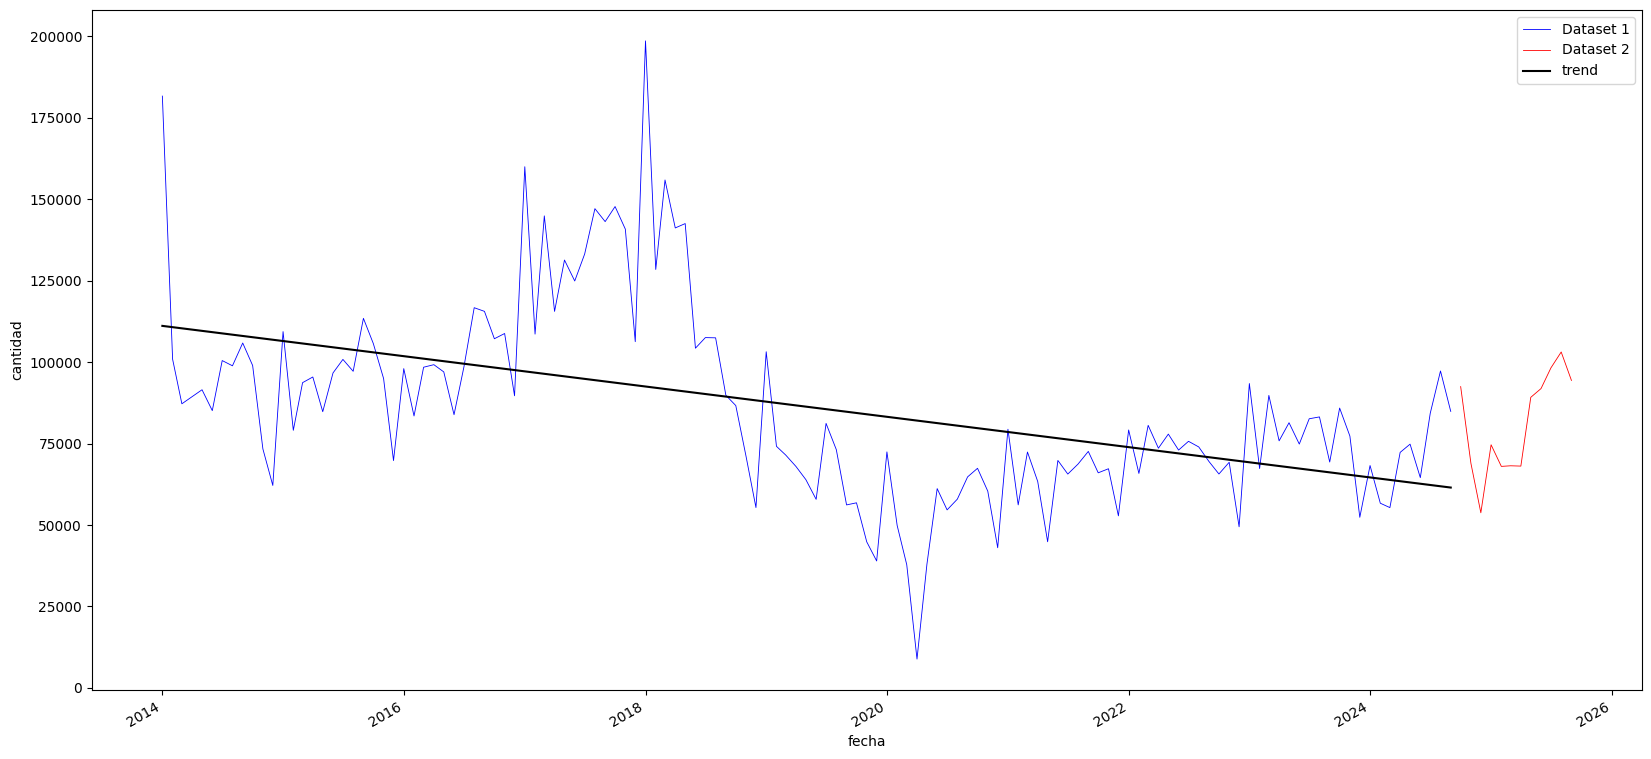

In [ ]:
# Create the plot
f, ax = plt.subplots(figsize=(20, 10))

# First line (df_grouped_n_out)
sns.lineplot(data=df_grouped, x="fecha", y="cantidad", linewidth=0.6, color='blue', ax=ax, label="Dataset 1")

# Second line (df_grouped_other)
#sns.lineplot(data=df_new, x=df_new.index, y="cantidad", linewidth=0.6, color='green', ax=ax, label="Dataset 2")

sns.lineplot(data=future_grouped, x=future_grouped.index, y="cantidad", linewidth=0.6, color='red', ax=ax, label="Dataset 2")


y_pred_l.plot(ax=ax,color='black',label='trend')

# Show the legend
ax.legend()

# Show the plot
plt.show()

El modelo parece detectar los diferentes períodos durante el año, además, coincide la leve tendencia lineal de crecimiento a partir de la caída en 2020. Podemos ver esto más a detalle si detallamos los meses en el gráfico.

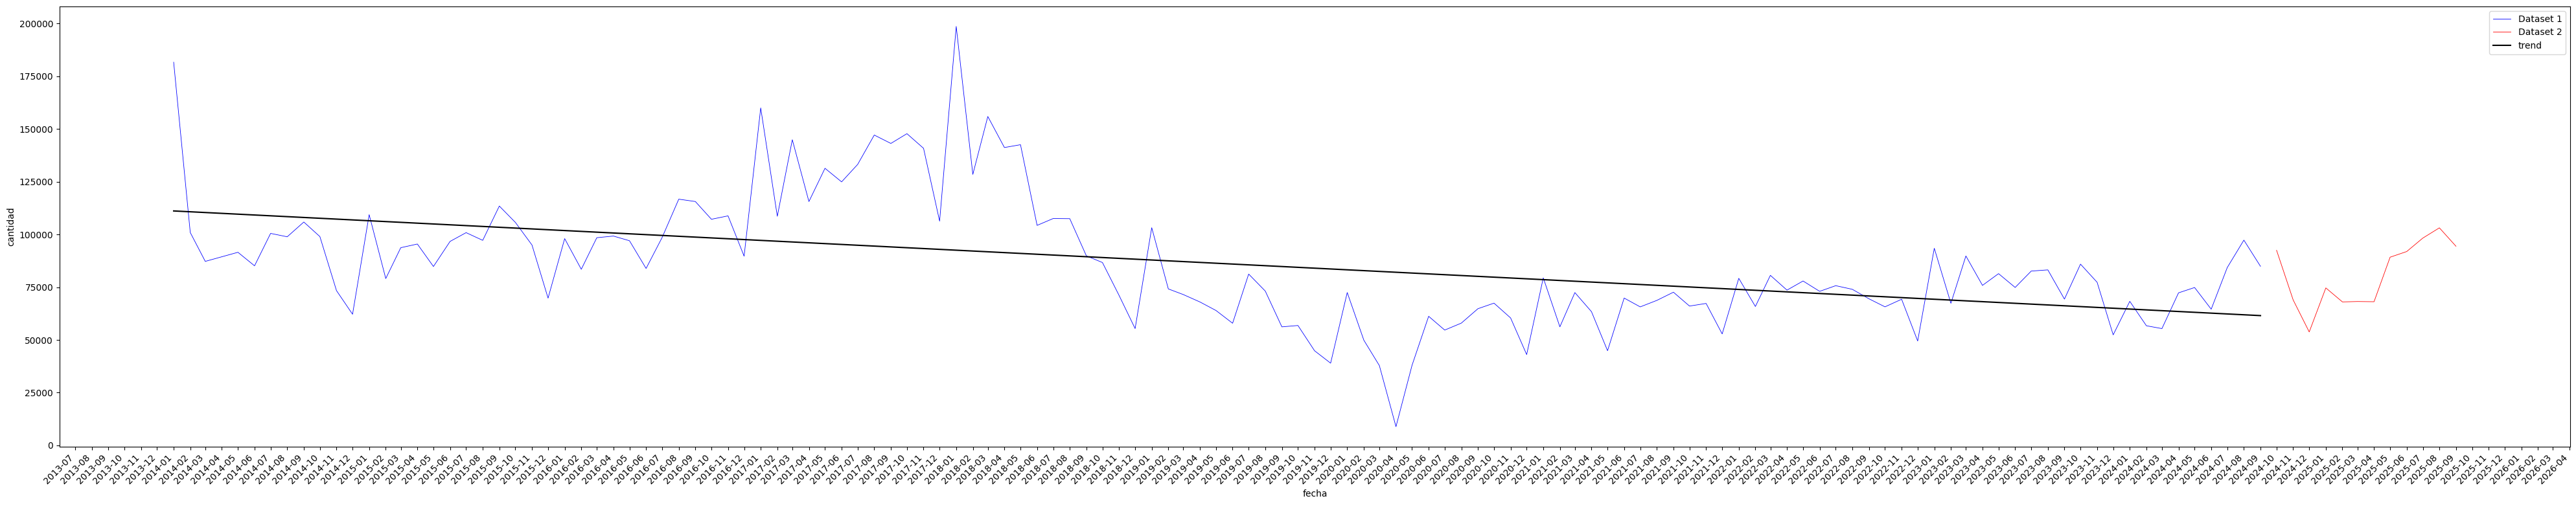

In [81]:
import matplotlib.dates as mdates

f, ax = plt.subplots(figsize=(50, 10))

# First line (df_grouped)
sns.lineplot(data=df_grouped, x="fecha", y="cantidad", linewidth=0.6, color='blue', ax=ax, label="Dataset 1")

# Second line (future_grouped)
sns.lineplot(data=future_grouped, x=future_grouped.index, y="cantidad", linewidth=0.6, color='red', ax=ax, label="Dataset 2")

# Predicted trend line
y_pred_l.plot(ax=ax, color='black', label='trend')

# Set major locator to show every month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Every month

# Format labels as "YYYY-MM"
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate for better readability
plt.xticks(rotation=45)

plt.legend()
plt.show()

Autor: Fernán Z L